In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
train = pd.read_csv('PATH')#path of csv file of training dataset
valid = pd.read_csv('PATH')#path of csv file of validation dataset

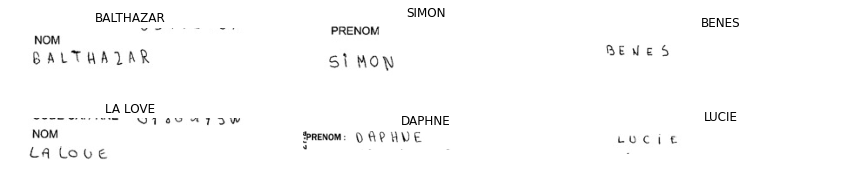

In [3]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'PATH'+train.loc[i, 'FILENAME']  # PATH= path of training data folder
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [4]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [5]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

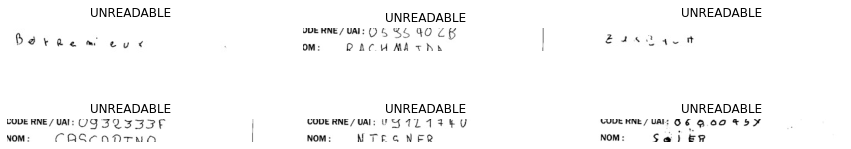

In [6]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'PATH'+unreadable.loc[i, 'FILENAME']   # PATH= path of training data folder
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [7]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [8]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [9]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

In [10]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [11]:
train_size = 34000
valid_size= 3000

In [12]:
train_x = []

for i in range(train_size):
    img_dir = 'PATH'+train.loc[i, 'FILENAME']  # PATH= path of training data folder
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [13]:
valid_x = []

for i in range(valid_size):
    img_dir = 'PATH'+valid.loc[i, 'FILENAME']  # PATH= path of VALIDATION data folder
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [14]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [15]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24
num_of_characters = len(alphabets) + 1 
num_of_timestamps = 64 

def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  
            break
        else:
            ret+=alphabets[ch]
    return ret

In [16]:
name = 'PRANJAL'
print(name, '\n',label_to_num(name))

PRANJAL 
 [15 17  0 13  9  0 11]


In [17]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    

In [18]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

In [19]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 64)      

In [20]:

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [21]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [22]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=50, batch_size=128)

Epoch 1/50
266/266 [==============================] - 39s 146ms/step - loss: 23.8568 - val_loss: 20.5262
Epoch 2/50
266/266 [==============================] - 37s 138ms/step - loss: 20.0947 - val_loss: 20.0353
Epoch 3/50
266/266 [==============================] - 36s 137ms/step - loss: 19.7372 - val_loss: 19.5339
Epoch 4/50
266/266 [==============================] - 36s 137ms/step - loss: 19.1678 - val_loss: 18.9752
Epoch 5/50
266/266 [==============================] - 36s 137ms/step - loss: 17.8935 - val_loss: 17.4291
Epoch 6/50
266/266 [==============================] - 36s 137ms/step - loss: 15.7859 - val_loss: 15.1437
Epoch 7/50
266/266 [==============================] - 37s 138ms/step - loss: 13.1250 - val_loss: 12.4381
Epoch 8/50
266/266 [==============================] - 36s 137ms/step - loss: 10.6959 - val_loss: 9.6562
Epoch 9/50
266/266 [==============================] - 36s 137ms/step - loss: 8.4956 - val_loss: 6.8016
Epoch 10/50
266/266 [==============================] - 36s

In [23]:
model_final.save_weights('model_weights2.h5')

In [24]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [25]:
model.save_weights('temp_weights.h5')

In [26]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 82.25%
Correct words predicted      : 69.90%


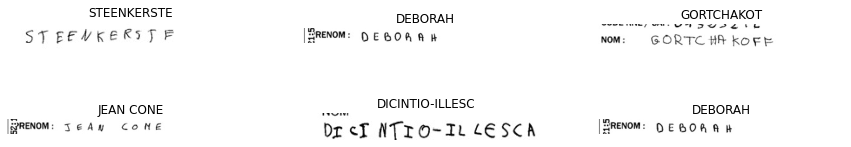

In [32]:
test = pd.read_csv('PATH')  # PATH = PATH OF TESTING DATA CSV
import random
plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'PATH'+test.loc[random.randint(6,46), 'FILENAME'] # PATH = PATH OF TEST DATA FOLDER
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

(-0.5, 324.5, 44.5, -0.5)

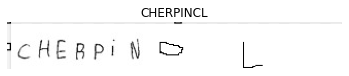

In [35]:
### import cv2
import matplotlib.pyplot as plt
from keras import backend as K

PATH = 'PATH'   # PATH= PATH OF IMAGE OF TESTING DATA
img = cv2.imread(PATH, cv2.IMREAD_GRAYSCALE)
plt.imshow(img , cmap='gray')
img = preprocess(img)
img = img/255.
pred = model.predict(img.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                       greedy=True)[0][0])
plt.title(num_to_label(decoded[0]), fontsize=12)
plt.axis('off')